In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE =256 
BATCH_SIZE =32
CHANNELS =3
EPOCHS = 50

In [3]:
# creating a pipline for my dataset  using TensorFlow's image_dataset_from_directory function
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle =True, 
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size =BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
## btw the labels for the images are based on the folder names , that's how images are categorized .. so basically the folder names are the class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

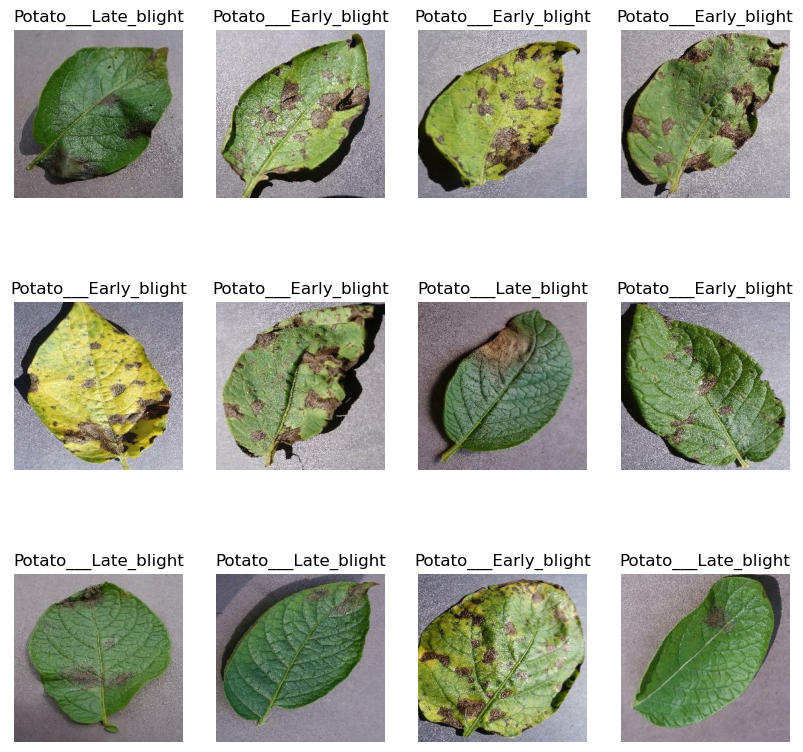

In [6]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):  
    # Loop through a single batch of the dataset.
    # `dataset.take(1)` takes only the first batch from the dataset.
    # `image_batch` contains the images, and `label_batch` contains their corresponding labels.

    for i in range(12):  # Loop through the first 12 images in the batch
        ax = plt.subplot(3, 4, i+1)  # Create a 3x4 grid of subplots
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
        plt.title(class_names[label_batch[i]])  # Set the title based on the label
        plt.axis("off")  # Hide the axis


In [7]:
# Splitting the dataset into training, validation, and test sets:
# - 80% of the data is used for training the model.
# - 10% of the data is used for validating the model during training (hyperparameter tuning, early stopping).
# - 10% of the data is reserved for testing the model after training to evaluate its performance on unseen data.

In [8]:
# Calculate the number of training samples (80% of the dataset)
train_size = 0.8
len(dataset) * train_size  # Number of samples for training

54.400000000000006

In [9]:
# Skip the first 54 batches (already used for training) and use the remaining data for testing and validation
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
# Calculate the number of samples for the validation set (10% of the total dataset)
val_size = 0.1
len(dataset) * val_size  # Number of samples for validation


6.800000000000001

In [11]:
## for our test data set 
test_ds = test_ds.skip(6)
len(test_ds)

8

In [12]:
def get_dataset_partitions_tf(ds, train_split =0.8, val_split =0.1, test_split =0.1, shuffle =True,  shuffle_size =10000):
    # Get the total size of the dataset
    ds_size =len(ds)
     # Shuffle the dataset if the 'shuffle' parameter is set to True
    if shuffle:
        ds =ds.shuffle(shuffle_size, seed =12) # Randomize the dataset with a buffer size
        
    # Calculate the number of samples for each split (train, validation, and test)
    train_size = int(train_split *ds_size) # Number of samples for training
    val_size = int(val_split * ds_size) # Number of samples for validation

    # Create the training dataset by taking the first 'train_size' samples
    train_ds =ds.take(train_size)
    # Create the validation dataset by skipping 'train_size' samples and taking 'val_size' samples
    val_ds = ds.skip(train_size).take(val_size)
     # Create the test dataset by skipping both 'train_size' and 'val_size' samples
    test_ds = ds.skip(train_size).skip(val_size)
    # Return the partitioned datasets
    return train_ds, val_ds,test_ds
    

In [13]:
# Call the 'get_dataset_partitions_tf' function to split the dataset into training, validation, and test sets
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

In [17]:
# Cache the dataset to improve performance by storing data in memory, then shuffle it with a buffer of 10,000 items, 
# and prefetch data to allow parallel loading while training for faster data processing.
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Same process applied to the validation dataset: caching, shuffling, and prefetching for efficient data pipeline.
val_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Same process applied to the test dataset to ensure efficient loading during evaluation.
test_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [18]:
# Create a sequential preprocessing pipeline
resize_and_rescale = tf.keras.Sequential([
   
   # Resize all images to a fixed size (IMAGE_SIZE x IMAGE_SIZE)
   tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
   
   # Rescale pixel values from [0, 255] to [0, 1] by dividing by 255
   tf.keras.layers.Rescaling(1.0/255)
])



In [22]:
#Data argumattion 

data_augmentation = tf.keras.Sequential([ 
   # Randomly flip the images horizontally
   tf.keras.layers.RandomFlip('horizontal_and_vertical'),
   # Randomly rotate images by up to 40 degrees
   tf.keras.layers.RandomRotation(0.2),
   # Randomly zoom into images by a factor of 0.2
   tf.keras.layers.RandomZoom(0.2),
   # Randomly change the brightness of the images
   tf.keras.layers.RandomBrightness(0.2)
])


#BUILD CNN AND TRAIN THIS NETWORK ON THE TRAIN DATASET AFTER WE HAVE DONE LOADING AND SOME PRE-PROCESSING UP

In [24]:

input_shapes = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes =3

model =models.Sequential([

    resize_and_rescale , # our first layer will be resizing and rescalling the image 
    data_augmentation ,# then data augmentation
    layers.Conv2D(32,(3,3),activation ='relu',input_shape= input_shapes), # third layer is the conv layer
    layers.MaxPooling2D((2,2)), ## fouth layer is max pooling to reduce the size of the image but at the same time keeping the most import features available
    layers.Conv2D(64, kernel_size=(3,3),activation ='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation ='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation ='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation ='relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(), # then a layer for flattening the out so that it's an  array  of neurons  and then a hidden layer next
    layers.Dense(64, activation ='relu') ,# then dense layer
    layers.Dense(n_classes, activation ='softmax'), # then my last layer will have three neurons
    
])

model.build(input_shape =input_shapes)

In [25]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (32, 2304)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 64)                    │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size =BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.4693 - loss: 1.1774 - val_accuracy: 0.4653 - val_loss: 0.9337
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.4566 - loss: 0.9226 - val_accuracy: 0.4711 - val_loss: 0.9342
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.4584 - loss: 0.9162 - val_accuracy: 0.4653 - val_loss: 0.8922
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.4864 - loss: 0.8922 - val_accuracy: 0.4711 - val_loss: 0.9045
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.4773 - loss: 0.8868 - val_accuracy: 0.4711 - val_loss: 0.8865
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.4594 - loss: 0.9091 - val_accuracy: 0.4711 - val_loss: 0.8852
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.4637 - loss: 0.8901 - val_accuracy: 0.4479 - val_loss: 0.8966
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4774 - loss: 0.8852 - val_accuracy: 0.4653 - v